In [13]:
from sklearn.metrics import (confusion_matrix, 
                             precision_score,
                             recall_score,
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np

from tqdm import trange, tqdm

import warnings
warnings.filterwarnings('ignore')

# Анализ датасета

In [35]:
df = pd.read_csv('diabetes.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [36]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


### Анализ пропущенных значений

In [37]:
print(f'Количество объектов с пропущенными значениями: {df.isnull().any(axis = 1).sum()}') 

Количество объектов с пропущенными значениями: 0


In [38]:
df = df[df['smoking_history'] != 'No Info']

### Перевод категориальных признаков в числовые

In [39]:
df['gender'] = LabelEncoder().fit_transform(df['gender'])
df = pd.concat([df.drop(['smoking_history'], axis = 1), pd.get_dummies(df['smoking_history'], dtype = int)], axis = 1)

df

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,current,ever,former,never,not current
0,0,80.0,0,1,25.19,6.6,140,0,0,0,0,1,0
2,1,28.0,0,0,27.32,5.7,158,0,0,0,0,1,0
3,0,36.0,0,0,23.45,5.0,155,0,1,0,0,0,0
4,1,76.0,1,1,20.14,4.8,155,0,1,0,0,0,0
5,0,20.0,0,0,27.32,6.6,85,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,0,26.0,0,0,34.34,6.5,160,0,0,0,0,1,0
99993,0,40.0,0,0,40.69,3.5,155,0,0,0,0,1,0
99997,1,66.0,0,0,27.83,5.7,155,0,0,0,1,0,0
99998,0,24.0,0,0,35.42,4.0,100,0,0,0,0,1,0


### Анализ выбросов

In [40]:
nums = []
ids = set()

for feature in df.drop(['diabetes'], axis = 1).columns:

    Q1 = df[feature].quantile(q = .25)
    Q3 = df[feature].quantile(q = .75)
    IQR = Q3 - Q1

    emissions = df[(df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)] 
    nums.append(emissions.shape[0])

    ids.update(emissions.index)

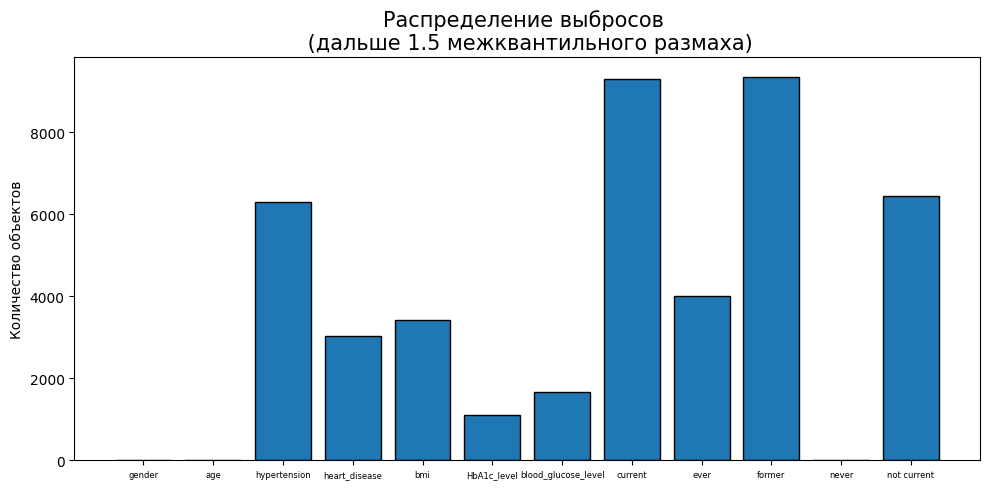

In [42]:
plt.figure(figsize = (10, 5))
plt.rc('xtick', labelsize = 6) 

plt.bar(df.drop(['diabetes'], axis = 1).columns, nums, edgecolor = 'black')

plt.ylabel('Количество объектов')
plt.title('Распределение выбросов \n (дальше 1.5 межквантильного размаха)', fontsize = 15)

plt.tight_layout()
plt.show()

In [43]:
df = df.drop(ids)

### Распределение классов

In [44]:
def classes_distr(df, title = None):
    plt.figure(figsize = (5, 5))
    plt.rc('xtick', labelsize = 10)

    plot = sns.countplot(x = 'diabetes', data = df, palette = ["#0101DF", "#DF0101"], edgecolor = 'black')

    for p in plot.patches:
        plot.annotate(int(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),  
                    ha = 'center', 
                    va = 'center', 
                    xytext = (0, 7), 
                    textcoords = 'offset points')

    plt.title(title, fontsize = 15, pad = 20)
    plt.show()

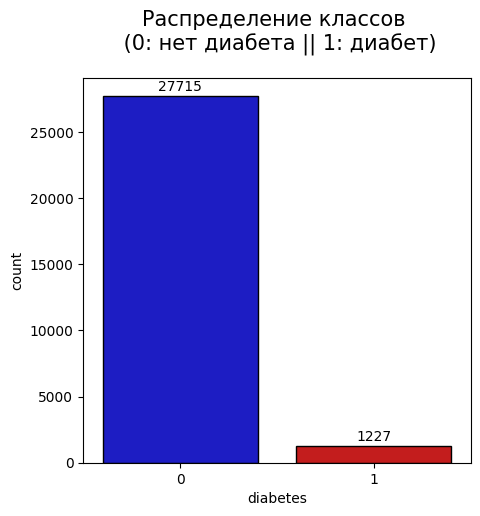

In [45]:
classes_distr(df, title = 'Распределение классов \n (0: нет диабета || 1: диабет)')

### Корреляция

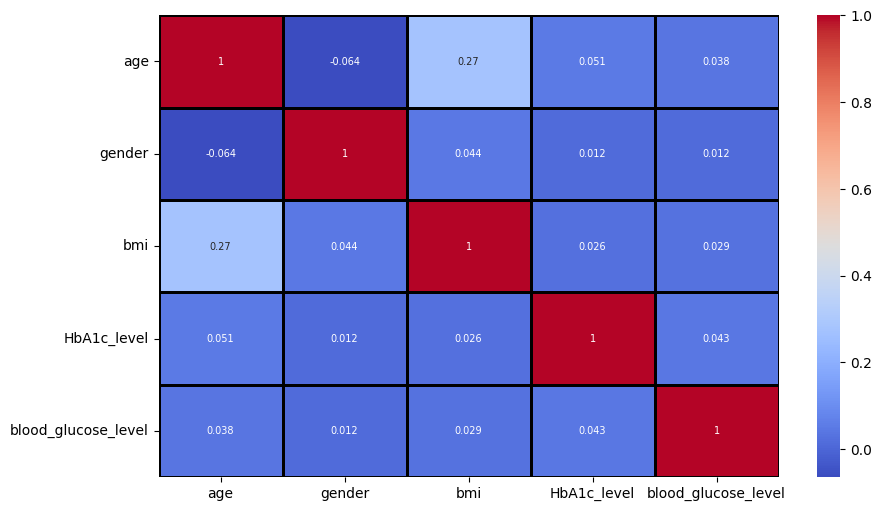

In [50]:
plt.figure(figsize = (10, 6))

sns.heatmap(df[['age', 'gender', 'bmi', 'HbA1c_level', 'blood_glucose_level']].corr(), 
            cmap = 'coolwarm', 
            linewidths = 2, 
            linecolor = 'black', 
            annot = True,
            annot_kws = {"fontsize" : 7})

plt.show()

# Задание 1

### Разделение на train и test

In [53]:
not_diabet = df[df['diabetes'] == 0]
diabet = df[df['diabetes'] == 1]

In [54]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(not_diabet.drop(['diabetes'], axis = 1), not_diabet['diabetes'], test_size = .2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(diabet.drop(['diabetes'], axis = 1), diabet['diabetes'], test_size = .2)

In [55]:
X_train = pd.concat([X_train1, X_train2]).sample(frac = 1)
X_test  = pd.concat([X_test1, X_test2]).sample(frac = 1)

y_train = pd.concat([y_train1, y_train2]).sample(frac = 1)
y_test = pd.concat([y_test1, y_test2]).sample(frac = 1)

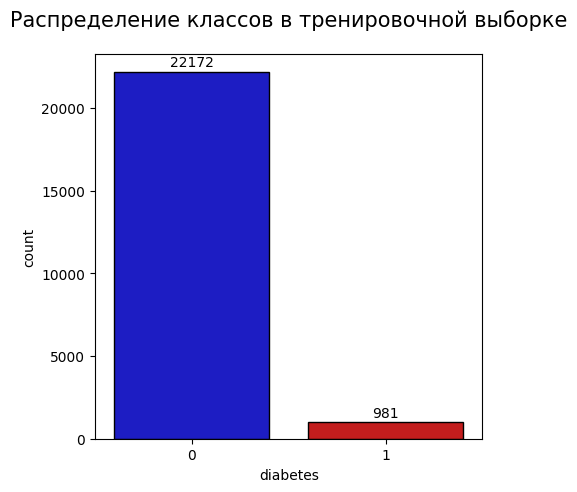

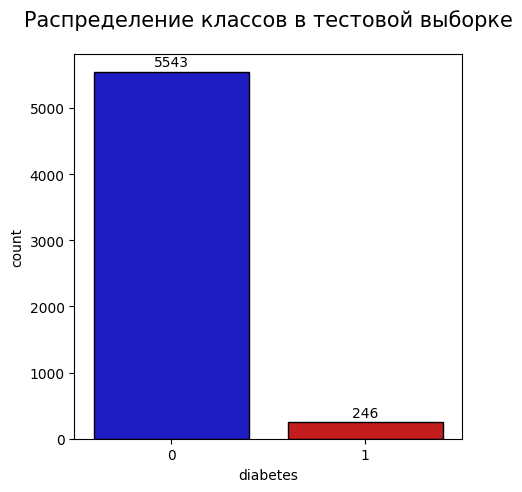

In [56]:
classes_distr(pd.DataFrame(y_train), title = 'Распределение классов в тренировочной выборке')
classes_distr(pd.DataFrame(y_test), title = 'Распределение классов в тестовой выборке')

### Классификация

In [57]:
weights = compute_sample_weight(class_weight = 'balanced', y = y_train)
np.unique(weights)

array([ 0.5221225 , 11.80071356])

In [58]:
estimator = GradientBoostingClassifier().fit(X_train, y_train, sample_weight = weights)
y_pred = estimator.predict(X_test)

<Figure size 600x600 with 0 Axes>

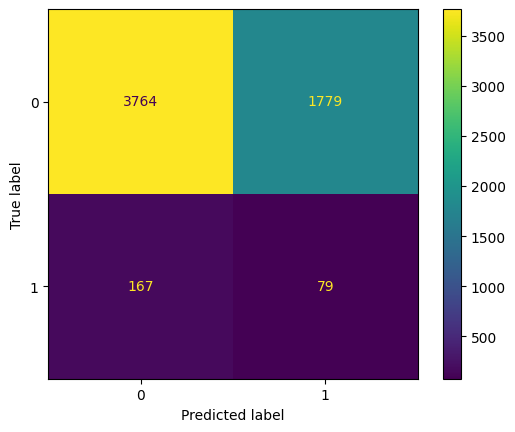

In [59]:
plt.figure(figsize = (6, 6))

ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)

plt.show()

# Задание 2

In [60]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
specificity = tn / (tn + fp) * 100

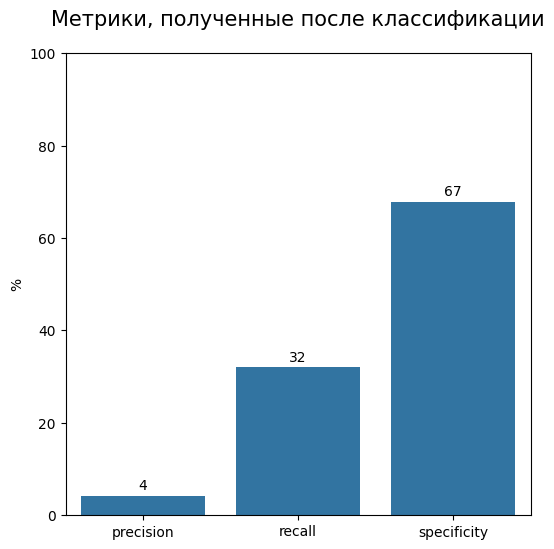

In [61]:
data = dict(x = ['precision', 'recall', 'specificity'], y = [precision, recall, specificity])
data = pd.DataFrame(data)

plt.figure(figsize = (6, 6))
plt.rc('xtick', labelsize = 10)

plot = sns.barplot(x = 'x', y = 'y', data = data)

for p in plot.patches:
    plot.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha = 'center', 
                va = 'center', 
                xytext = (0, 7), 
                textcoords = 'offset points')

plt.ylim([0, 100])

plt.xlabel('')
plt.ylabel('%')

plt.title('Метрики, полученные после классификации', fontsize = 15, pad = 20)
plt.show()

# Задание 3

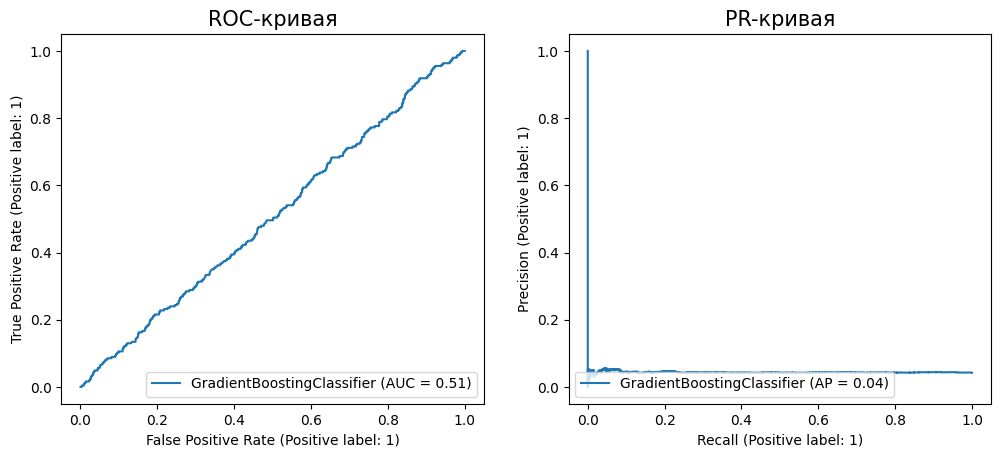

In [62]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax = ax[0])
PrecisionRecallDisplay.from_estimator(estimator, X_test, y_test, ax = ax[1])

ax[0].set_title('ROC-кривая', fontsize = 15)
ax[1].set_title('PR-кривая', fontsize = 15)

plt.show()

# Задание 4

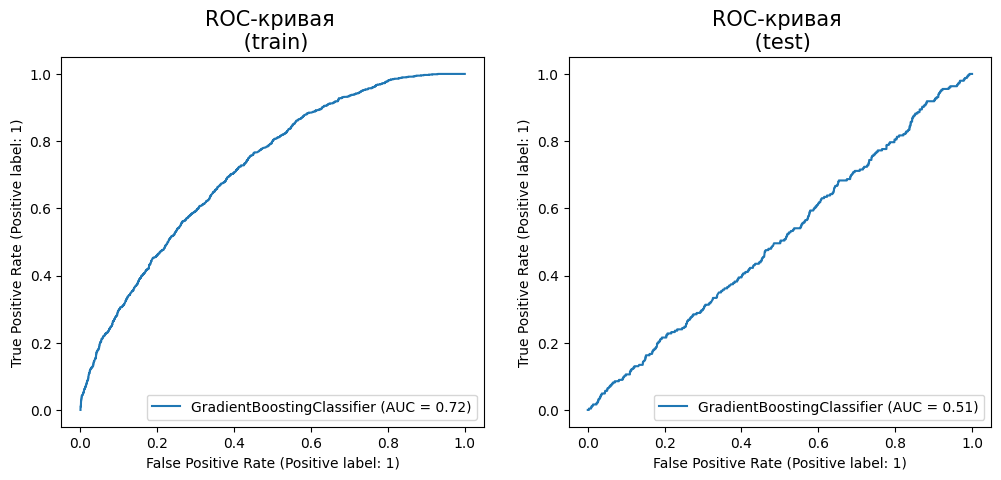

In [63]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

RocCurveDisplay.from_estimator(estimator, X_train, y_train, ax = ax[0])
RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax = ax[1])

ax[0].set_title('ROC-кривая \n (train)', fontsize = 15)
ax[1].set_title('ROC-кривая \n (test)', fontsize = 15)

plt.show()

# Задание 5

In [64]:
ada_boost_aucs = []
grad_boost_aucs = []

for n_estimators in trange(50, 100):

    ada_boost = AdaBoostClassifier(n_estimators = n_estimators).fit(X_train, y_train, sample_weight = weights)
    grad_boost = GradientBoostingClassifier(n_estimators = n_estimators).fit(X_train, y_train, sample_weight = weights)

    ada_boost_aucs.append(roc_auc_score(y_test, ada_boost.predict(X_test)) * 100)
    grad_boost_aucs.append(roc_auc_score(y_test, grad_boost.predict(X_test)) * 100)

100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


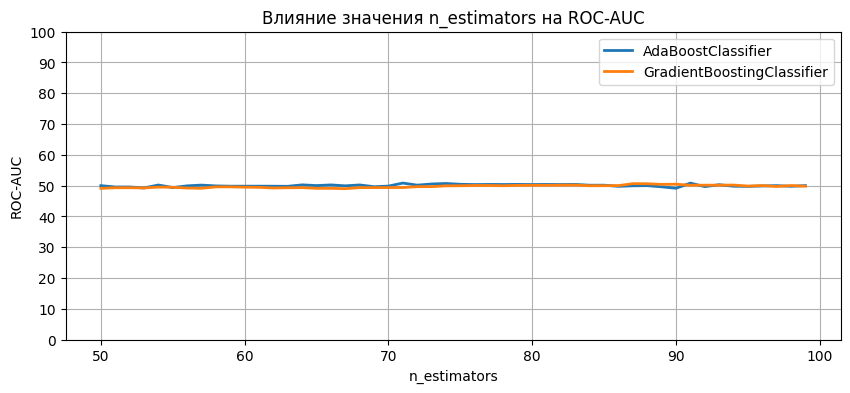

In [65]:
plt.figure(figsize = (10, 4))

plt.plot(range(50, 100), ada_boost_aucs, linewidth = 2, label = 'AdaBoostClassifier')
plt.plot(range(50, 100), grad_boost_aucs, linewidth = 2, label = 'GradientBoostingClassifier')

plt.xlabel('n_estimators') 
plt.ylabel('ROC-AUC')

plt.yticks(range(0, 101, 10))

plt.title('Влияние значения n_estimators на ROC-AUC')

plt.legend()
plt.grid()

plt.show()

In [66]:
ada_boost_aucs = []
grad_boost_aucs = []

for learning_rate in tqdm(np.arange(0.01, 1, 0.05)):

    ada_boost = AdaBoostClassifier(learning_rate  = learning_rate ).fit(X_train, y_train, sample_weight = weights)
    grad_boost = GradientBoostingClassifier(learning_rate  = learning_rate ).fit(X_train, y_train, sample_weight = weights)

    ada_boost_aucs.append(roc_auc_score(y_test, ada_boost.predict(X_test)) * 100)
    grad_boost_aucs.append(roc_auc_score(y_test, grad_boost.predict(X_test)) * 100)

100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


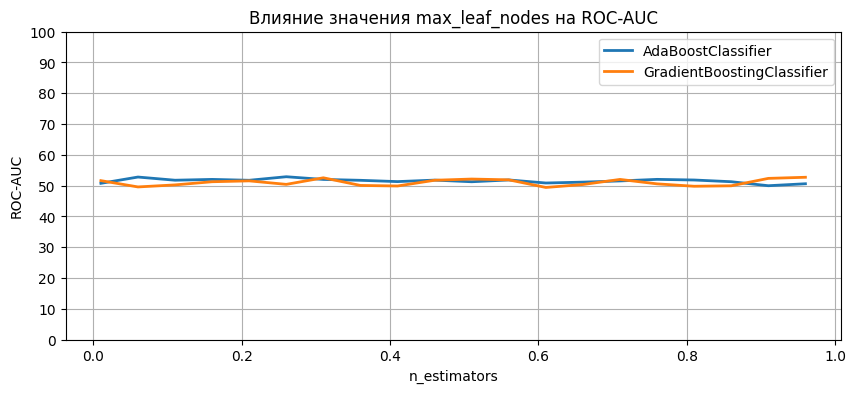

In [68]:
plt.figure(figsize = (10, 4))

plt.plot(np.arange(0.01, 1, 0.05), ada_boost_aucs, linewidth = 2, label = 'AdaBoostClassifier')
plt.plot(np.arange(0.01, 1, 0.05), grad_boost_aucs, linewidth = 2, label = 'GradientBoostingClassifier')

plt.xlabel('n_estimators') 
plt.ylabel('ROC-AUC')

plt.yticks(range(0, 101, 10))

plt.title('Влияние значения max_leaf_nodes на ROC-AUC')

plt.legend()
plt.grid()

plt.show()